## Pix2pix Generative Adversarial CNN 
- Implemented on Reflectance Confocal Microscopy and Second Harmonic Generation Microscopy images of Biological Tissue Collected at WilsonLab CSU
- Code based on pix2pix example from the original authors at Google
- Not all notebook features functional, many parts of the code still being modified
- Written by Arya Chowdhury Mugdha (arya.mugdha@colostate.edu) and Jesse W. Wilson

### Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
# tf.enable_eager_execution() # enabled by default on TF 2.x. For running on TF 1.x, need to enable eager execution. **CSU**

import os
import time
import cv2 
import numpy as np
import os.path
from os import path

from matplotlib import pyplot as plt
from IPython import display

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10440538065717627184
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13360007755864981188
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2186824252667234920
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23119489920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13278199804178162676
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6"
]


### Check Paths

In [4]:
! pwd

/home/arya1080/python_projects/tensorflow


In [5]:
PATH = "./datasets/20200416_alldata_png256/" 

In [6]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
# define the image loader
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image,channels=3) 

    # the following hack needed for tensorflow 1.x 
    image.set_shape([IMG_HEIGHT, 2*IMG_WIDTH, 3]) 

    w = tf.shape(image)[1]

    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

(256, 256, 3)
(256, 256, 3)


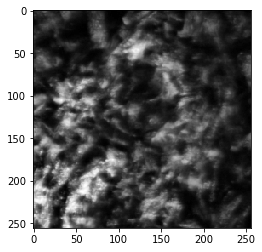

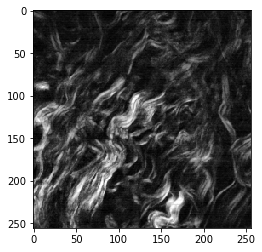

In [8]:
# plot some sample RCM and SHG images
inp, re = load(PATH+'train/191209_002_1.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255)
plt.figure()
plt.imshow(re/255)
print( inp.shape)
print( re.shape)

### Define image augmentation functions in tensorflow

In [9]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [11]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random horizontal mirroring 
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)


    if tf.random.uniform(()) > 0.5:  
        # random vertical mirroring 
        input_image = tf.image.flip_up_down(input_image) 
        real_image = tf.image.flip_up_down(real_image) 

    # random rotations 
    k = tf.random.uniform((),minval=0,maxval=3,dtype='int32') 
    input_image = tf.image.rot90(input_image,k) 
    real_image = tf.image.rot90(real_image,k) 

    return input_image, real_image

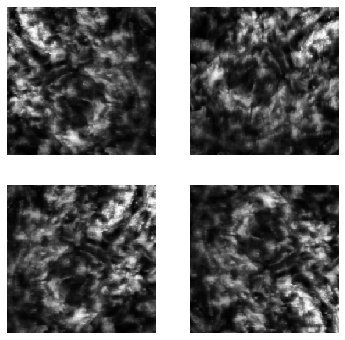

(256, 256, 3)


In [13]:
# check some of the functions
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()
print(inp.shape)

### Input image loader pipeline

In [14]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [15]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [16]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png') 
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png') 
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [20]:
print(inp.shape)

(256, 256, 3)


In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [22]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [23]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [24]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
# display the summary of the built generator network
with tf.device('/device:GPU:0'):
    generator = Generator()
    generator.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
_______________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


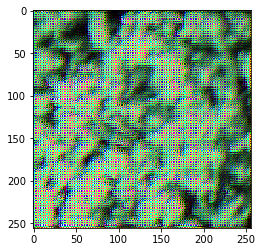

In [26]:
with tf.device('/device:GPU:0'):
    gen_output = generator(inp[tf.newaxis,...], training=False)
    plt.imshow(gen_output[0,...])

In [100]:
# define per iteration image generation function
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    
    bce_loss_object = tf.keras.losses.BinaryCrossentropy()
    gen_output = prediction[0]
    target = tar[0]

    # binary cross-entropy for binarized images  
    th = tf.constant(0, dtype = tf.float32)

    target_bin = tf.math.greater(target, th)
    gen_output_bin = tf.math.greater(gen_output, th)

    target_bin = tf.dtypes.cast(target_bin, dtype = tf.float32)
    gen_output_bin = tf.dtypes.cast(gen_output_bin, dtype = tf.float32)
    plt.imshow(target_bin)
    plt.show()
    plt.figure()
    plt.imshow(gen_output_bin)
    plt.show()

    bce = bce_loss_object(target_bin, gen_output_bin)
    print(bce)

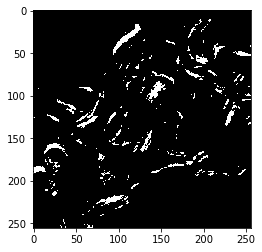

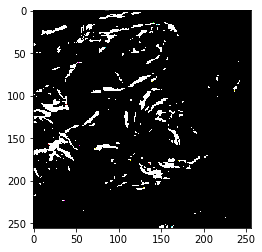

tf.Tensor(1.4526106, shape=(), dtype=float32)


In [101]:
with tf.device('/device:GPU:0'):

    for example_input, example_target in test_dataset.take(1):
      generate_images(generator, example_input, example_target)

In [65]:
LAMBDA = 0
LAMBDA2 = 20

bce_loss_object = tf.keras.losses.BinaryCrossentropy()

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # binary cross-entropy for binarized images  
  th = tf.constant(0, dtype = tf.float32)
    
  target_bin = tf.math.greater(target, th)
  gen_output_bin = tf.math.greater(gen_output, th)
    
  target_bin = tf.dtypes.cast(target_bin, dtype = tf.float32)
  gen_output_bin = tf.dtypes.cast(gen_output_bin, dtype = tf.float32)
  target_bin_img = target_bin.numpy()
  plt.imshow(target_bin_img[0,...])

#   print('target bin:',target_bin)
#   print('gen_output_bin:',gen_output_bin)

  bce = bce_loss_object(target_bin, gen_output_bin)
 
  total_gen_loss = gan_loss + (LAMBDA * l1_loss) + (LAMBDA2 * bce)

  return total_gen_loss, gan_loss, l1_loss, bce

### Build the Discriminator

In [66]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [67]:
with tf.device('/device:GPU:0'):
    discriminator = Discriminator()
    discriminator.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 128, 128, 64) 6144        concatenate_9[0][0]   

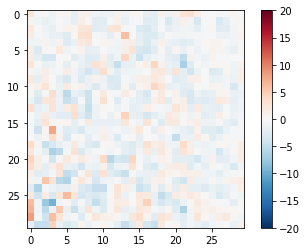

In [68]:
with tf.device('/device:GPU:0'):

    disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
    plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
    plt.colorbar()

### Define the loss function

In [69]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [70]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the Optimizers and Checkpoint-saver




In [86]:
exp_name = '20201214_1'

In [87]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [88]:
checkpoint_dir = './checkpoints/training_checkpoints_' + str(exp_name)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [74]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

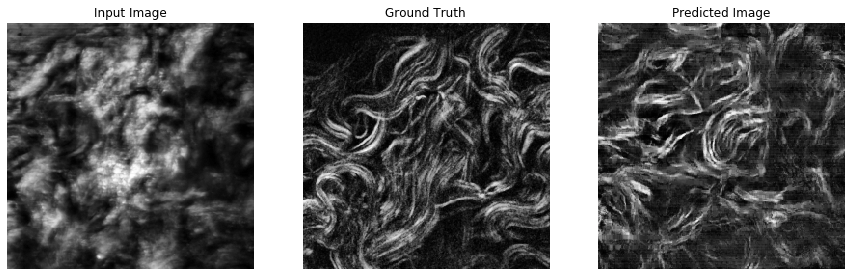

In [91]:
with tf.device('/device:GPU:0'):

    for example_input, example_target in test_dataset.take(1):
      generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [76]:
!ls ./logs/

20201214_1  20201214_2


In [77]:
logpath = "./logs/" + str(exp_name)
if not path.exists(logpath):
    os.makedirs("./logs/" + str(exp_name))

In [78]:
EPOCHS = 200

In [79]:
!rm -r ./logs/{exp_name}/*

In [80]:
summary_writer = tf.summary.create_file_writer(
    "./logs/" + str(exp_name))
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_bce_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

# tensorboard updates 
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    tf.summary.scalar('bce_loss', gen_bce_loss, step=epoch)


In [81]:
!ls ./logs/{exp_name}

events.out.tfevents.1607989950.lambda-dual.8218.253153.v2


In [82]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

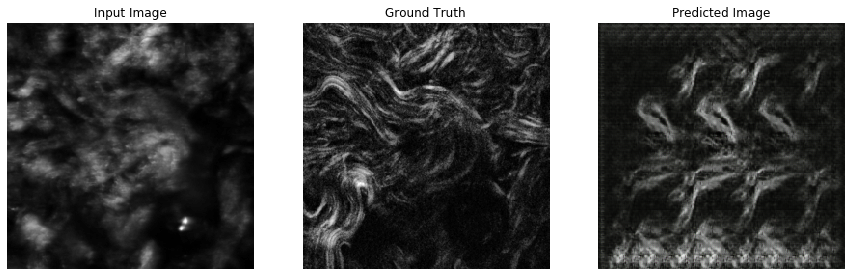

Epoch:  0
.

AttributeError: in user code:

    <ipython-input-42-04ed35949517>:11 train_step  *
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_bce_loss = generator_loss(disc_generated_output, gen_output, target)
    <ipython-input-65-d07cc2552ece>:20 generator_loss  *
        target_bin_img = target_bin.numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [83]:
with tf.device('/device:GPU:0'):

    fit(train_dataset, EPOCHS, test_dataset)

## Restore the latest checkpoint and test

In [89]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [90]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

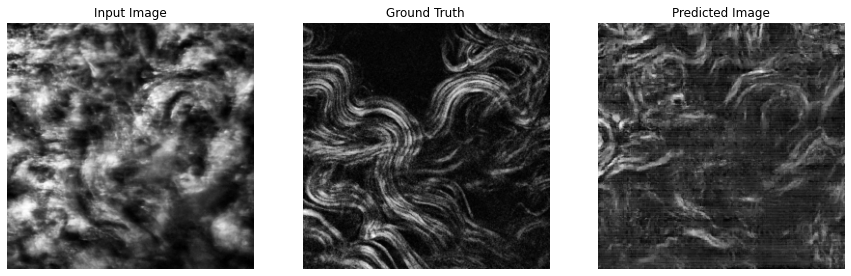

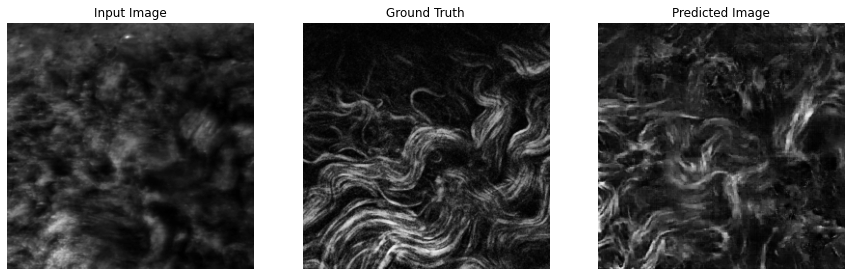

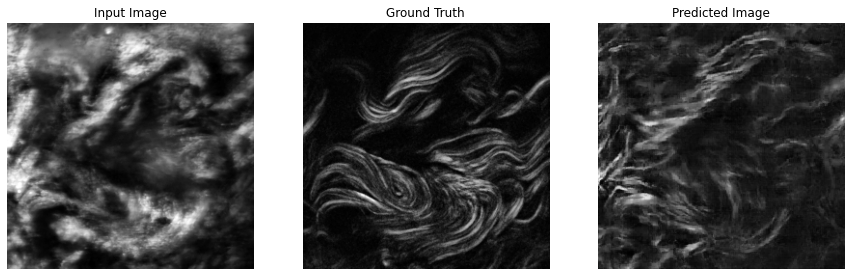

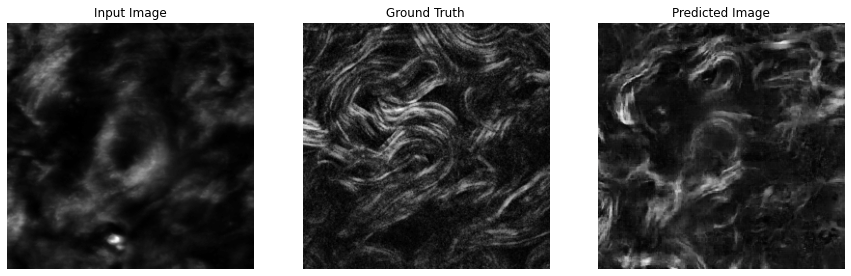

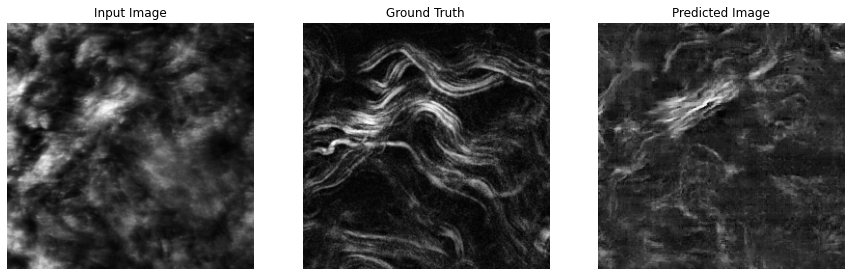

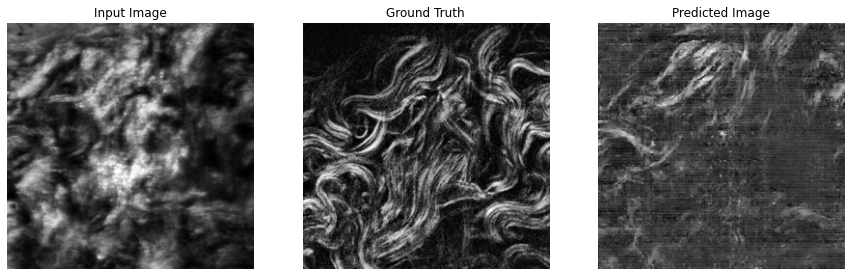

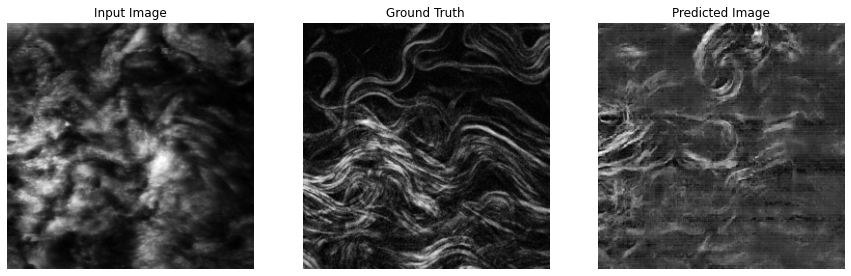

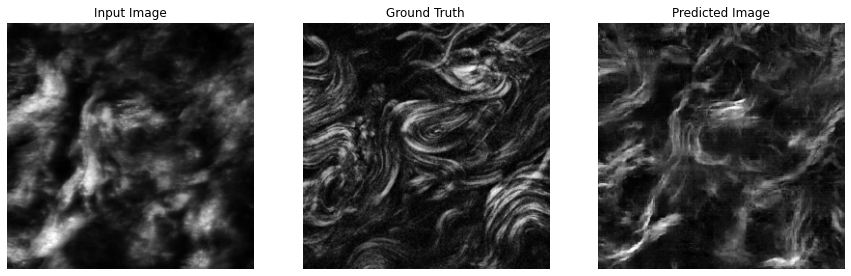

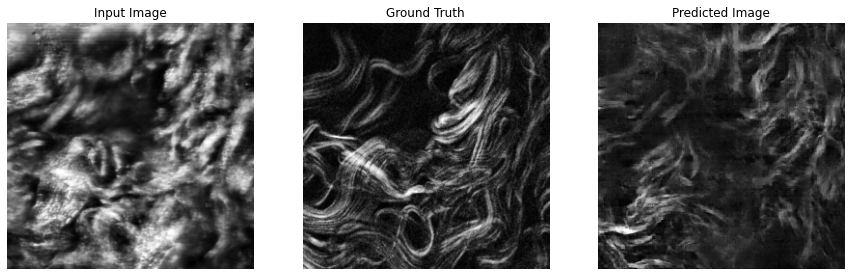

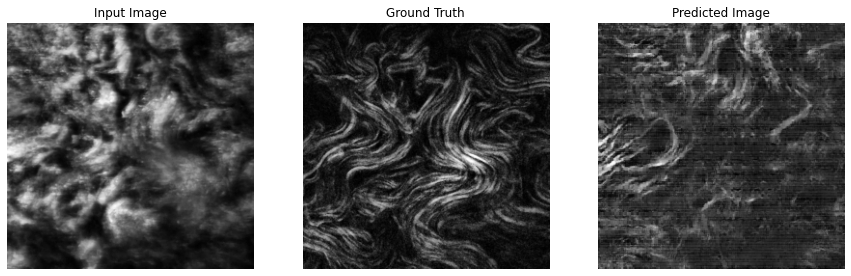

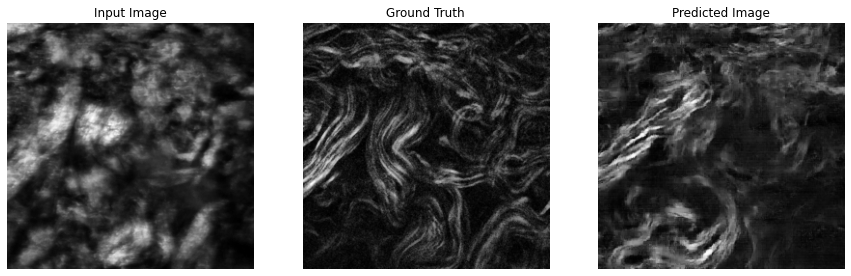

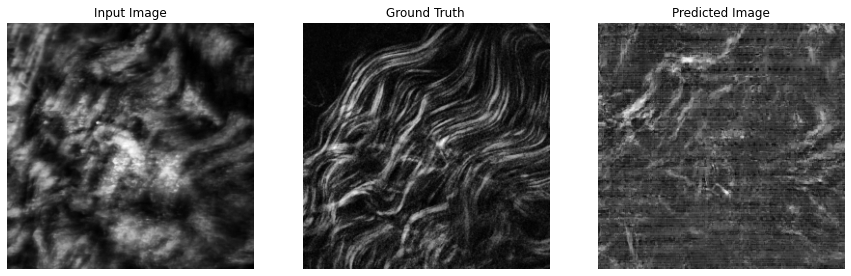

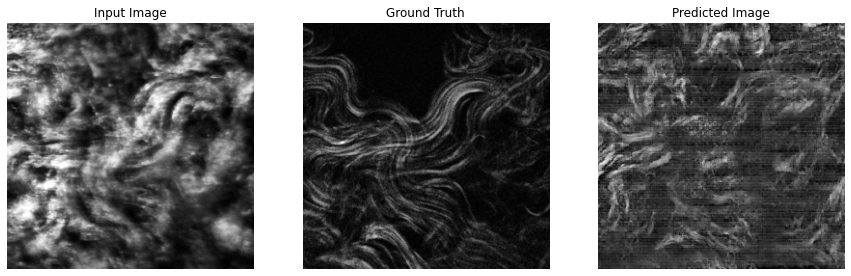

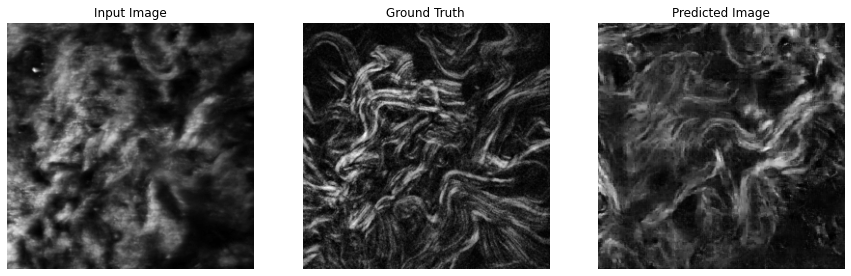

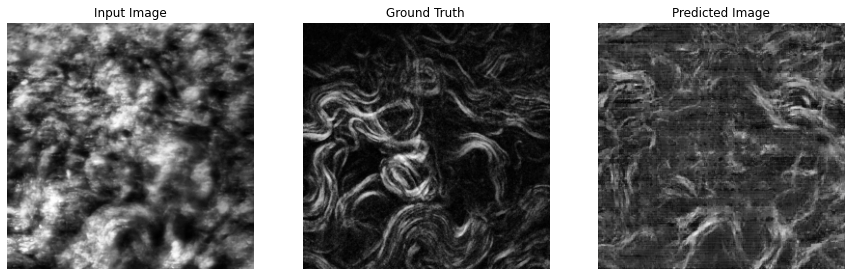

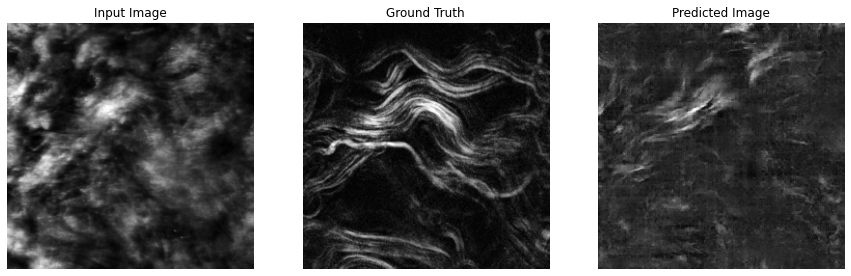

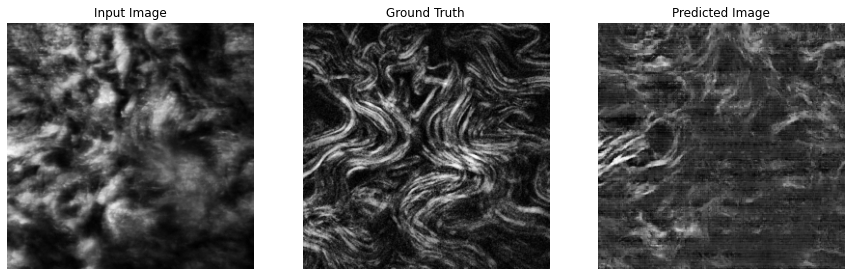

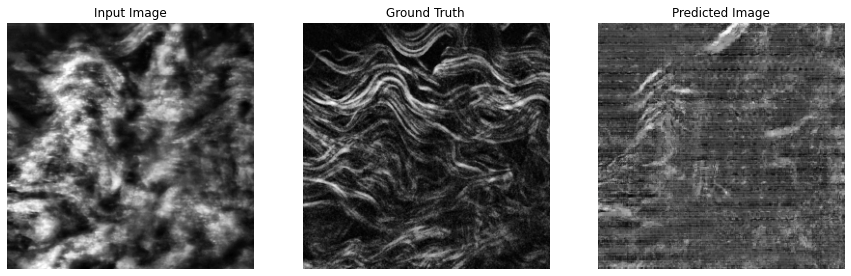

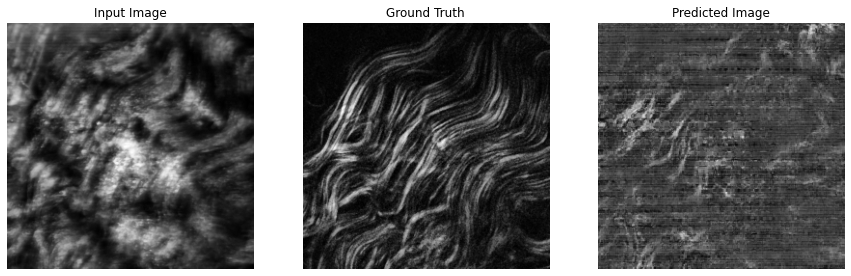

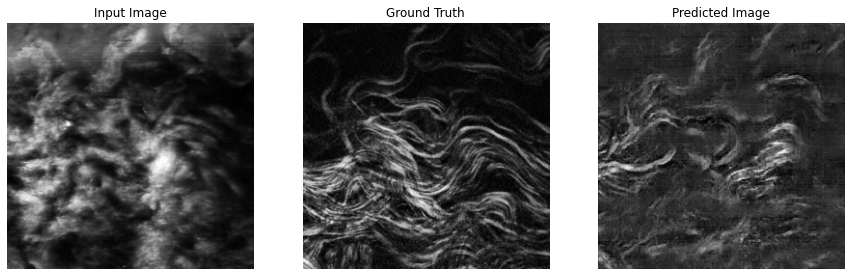

In [43]:
# Run the trained model on a few examples from the test dataset
test_dataset_shuff = test_dataset.shuffle(BUFFER_SIZE)
for inp, tar in test_dataset.take(20):
  generate_images(generator, inp, tar)

## Compute performance metrics

In [53]:
train_dataset_shuff = train_dataset.shuffle(BUFFER_SIZE)
pr_score_train = []
ssim_score_train = []
mse_score_train = []
for inp, tar in train_dataset.take(BUFFER_SIZE):
    pr, ssim, mse = report_score(generator, inp, tar)
    pr_score_train.append(pr)
    ssim_score_train.append(ssim)
    mse_score_train.append(mse)


test_dataset_shuff = test_dataset.shuffle(BUFFER_SIZE)
pr_score_test = []
ssim_score_test = []
mse_score_test = []
for inp, tar in test_dataset.take(BUFFER_SIZE):
    pr, ssim, se = report_score(generator, inp, tar)
    pr_score_test.append(pr)
    ssim_score_test.append(ssim)
    mse_score_test.append(mse)


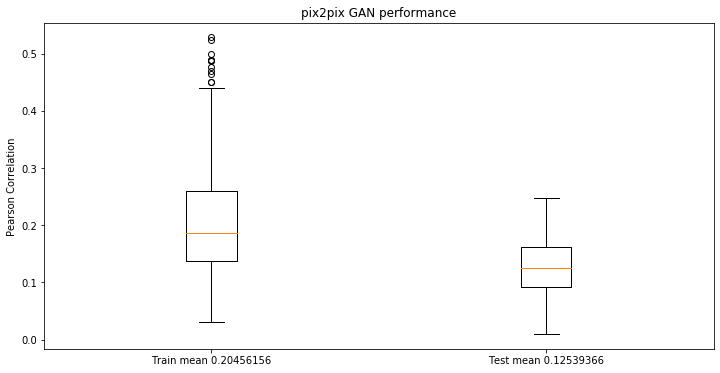

In [54]:
pr_total = [pr_score_train, pr_score_test]
plt.figure(figsize=(12,6))
plt.boxplot(pr_total)
plt.xticks([1, 2],['Train mean '+str(tf.math.reduce_mean(pr_score_train).numpy()), 
                   'Test mean '+str(tf.math.reduce_mean(pr_score_test).numpy())])
plt.ylabel('Pearson Correlation')
plt.title('pix2pix GAN performance')
plt.show()

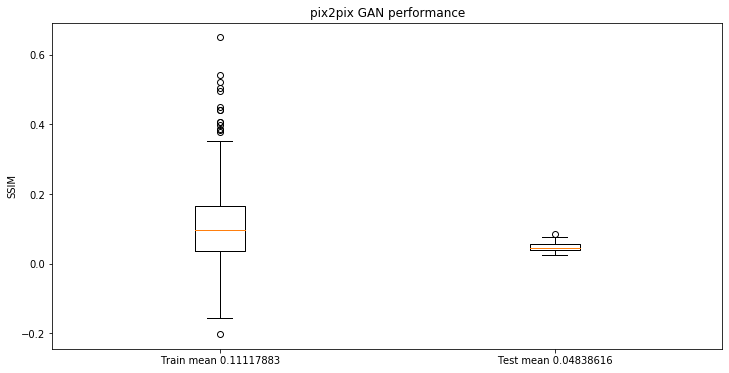

In [120]:
ssim_total = [ssim_score_train, ssim_score_test]
plt.figure(figsize=(12,6))
plt.boxplot(ssim_total)
plt.xticks([1, 2],['Train mean '+str(tf.math.reduce_mean(ssim_score_train).numpy()), 
                   'Test mean '+str(tf.math.reduce_mean(ssim_score_test).numpy())])
plt.ylabel('SSIM')
plt.title('pix2pix GAN performance')
plt.show()

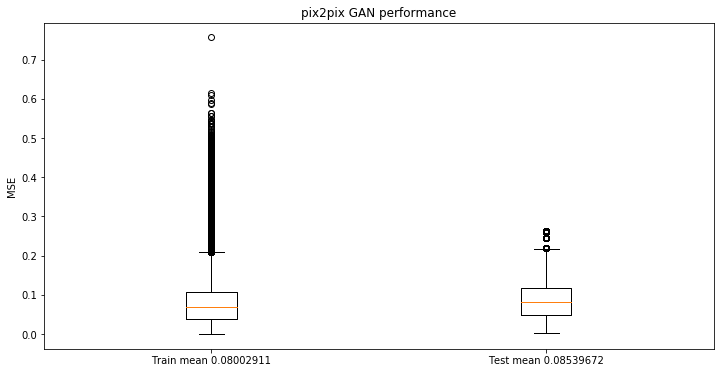

In [55]:
mse_total = [mse_score_train, mse_score_test]
plt.figure(figsize=(12,6))
plt.boxplot(mse_total)
plt.xticks([1, 2],['Train mean '+str(tf.math.reduce_mean(mse_score_train).numpy()), 
                   'Test mean '+str(tf.math.reduce_mean(mse_score_test).numpy())])
plt.ylabel('MSE')
plt.title('pix2pix GAN performance')
plt.show()

In [39]:
def fit2(train_ds, epochs, test_ds):
  global pr_train, pr_test, ssim_train, ssim_test, mse_train, mse_test
  pr_train = []
  pr_test = [] 
  ssim_train = []
  ssim_test = [] 
  mse_train = [] 
  mse_test = []
  for epoch in range(epochs):

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()
    
    pr_score_train = []
    ssim_score_train = []
    mse_score_train = []
    for inp, tar in train_ds.take(BUFFER_SIZE):
        pr, ssim, mse = report_score(generator, inp, tar)
        pr_score_train.append(pr)
        ssim_score_train.append(ssim)
        mse_score_train.append(mse)
    pr_train.append(tf.math.reduce_mean(pr_score_train).numpy())
    ssim_train.append(tf.math.reduce_mean(ssim_score_train).numpy())
    mse_train.append(tf.math.reduce_mean(mse_score_train).numpy())

    pr_score_test = []
    ssim_score_test = []
    mse_score_test = []
    for inp, tar in test_ds.take(BUFFER_SIZE):
        pr, ssim, se = report_score(generator, inp, tar)
        pr_score_test.append(pr)
        ssim_score_test.append(ssim)
        mse_score_test.append(mse)
    pr_test.append(tf.math.reduce_mean(pr_score_test).numpy())
    ssim_test.append(tf.math.reduce_mean(ssim_score_test).numpy())
    mse_test.append(tf.math.reduce_mean(mse_score_test).numpy())
    
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  checkpoint.save(file_prefix = checkpoint_prefix)

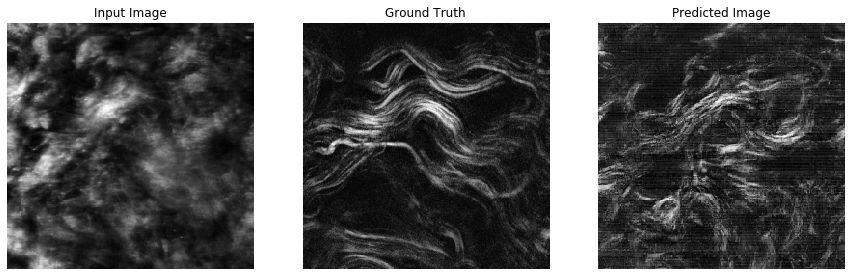

Epoch:  249
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................

In [42]:
with tf.device('/device:GPU:0'):

    fit2(train_dataset, 250, test_dataset)

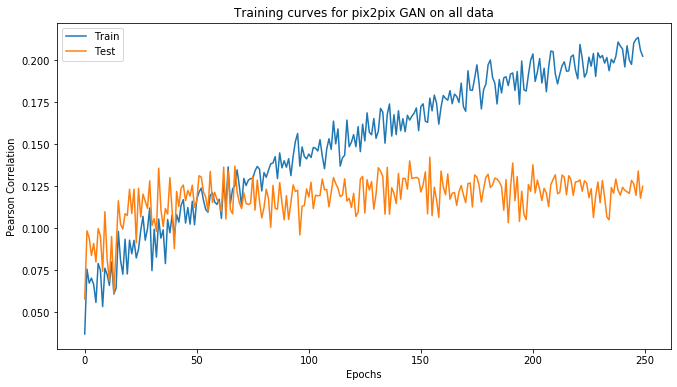

In [46]:
plt.figure(figsize=(11,6))
plt.plot(pr_train, label='Train')
plt.plot(pr_test, label='Test')
plt.ylabel('Pearson Correlation')
plt.xlabel('Epochs')
plt.title('Training curves for pix2pix GAN on all data')
plt.legend(loc='best')
plt.show()

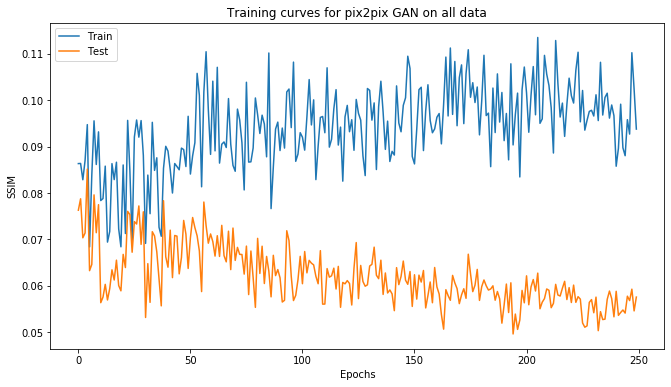

In [47]:
plt.figure(figsize=(11,6))
plt.plot(ssim_train, label='Train')
plt.plot(ssim_test, label='Test')
plt.ylabel('SSIM')
plt.xlabel('Epochs')
plt.title('Training curves for pix2pix GAN on all data')
plt.legend(loc='best')
plt.show()

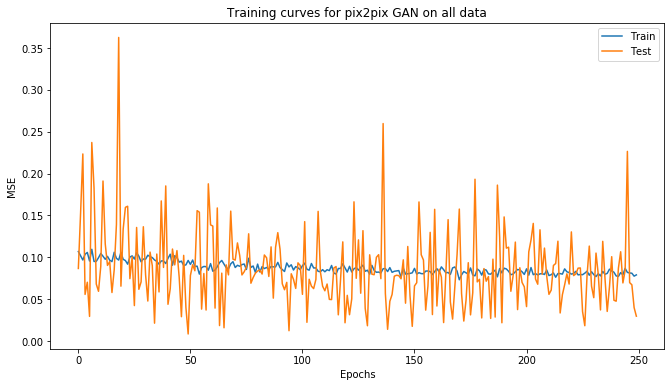

In [49]:
plt.figure(figsize=(11,6))
plt.plot(mse_train, label='Train')
plt.plot(mse_test, label='Test')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.title('Training curves for pix2pix GAN on all data')
plt.legend(loc='best')
plt.show()